In [7]:
import sys
sys.path.insert(0, "..")

In [8]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [43]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "FFSnow"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [45]:
df = get_dataframe(aspect_path, "FFSnow")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
df.drop_duplicates(inplace=True)
len(df)

15

In [46]:
def get_mapping(series):
    aspect_raster = access_raster(series['FFSnow'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

def fit_curve(x, y, ax): 
    def test_func(x, a, b, c, d):
        return a * x**3 + b * x**2 + c * x + d

    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0, 1, 0],
                                                    method="trf", absolute_sigma=True, maxfev=5000)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        
    # plt.figure(figsize=(6, 4))
    # plt.scatter(x, y, label='Data', s=1)

    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1], params[2], params[3])
    ax.plot(x, fitted_y,
            label='Linear regression', color="red")
    ax.legend(loc='best')
    plt.show()    
    
    get_str = lambda x:  f"{round(x, 2)}"
    a, b, c, d = params
    print(f"Fitted function: {get_str(a)} * x^3 + {get_str(b)} * x^2 + {get_str(c)} * x + {get_str(d)}")
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    
    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 2))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values
    plot_map(new_mapping)
    return new_mapping

____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


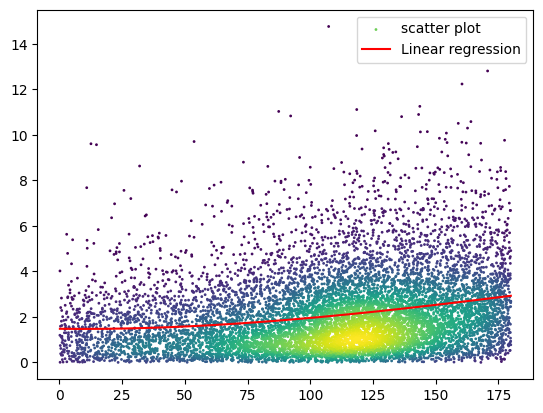

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.0 * x + 1.48
MSE: 2.649345
R^2: 0.05770999193191528


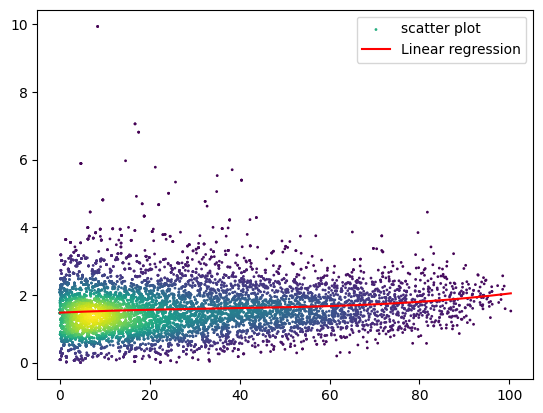

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.48
MSE: 0.5078847340637289
R^2: 0.012864046650611582
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


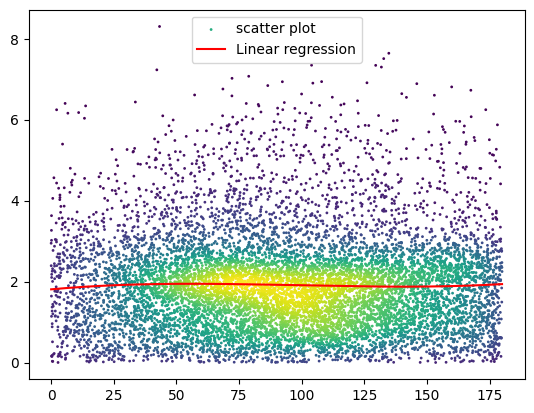

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.81
MSE: 1.3657986
R^2: 0.000545799732208252


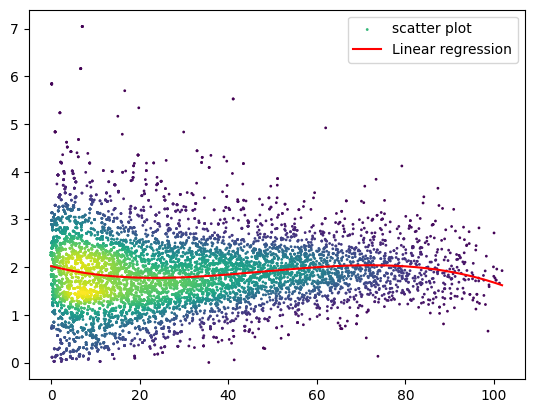

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.02 * x + 2.02
MSE: 0.5606693581359459
R^2: 0.01300247948177502
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


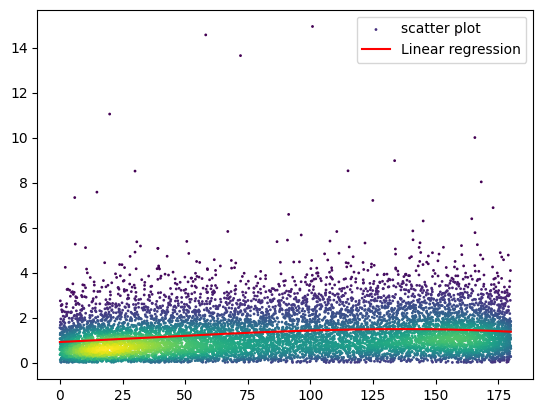

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.01 * x + 0.91
MSE: 0.9182343
R^2: 0.03712350130081177


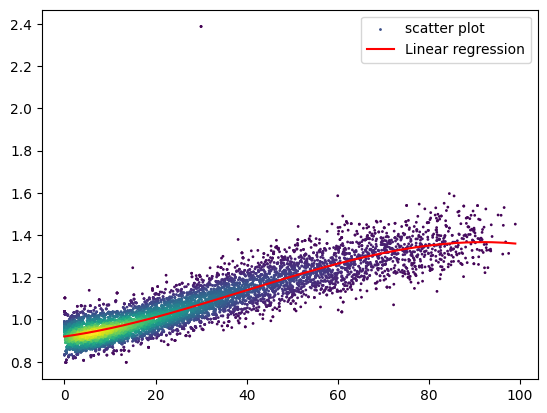

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 0.92
MSE: 0.003536034200687996
R^2: 0.8189199799361246
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


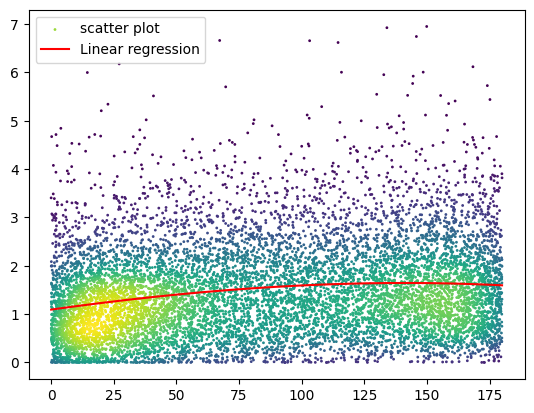

Fitted function: -0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.09
MSE: 0.88743293
R^2: 0.03451681137084961


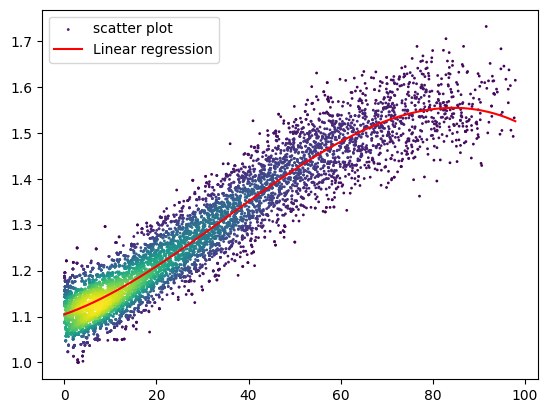

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.1
MSE: 0.0020456734711893155
R^2: 0.897574361435462
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


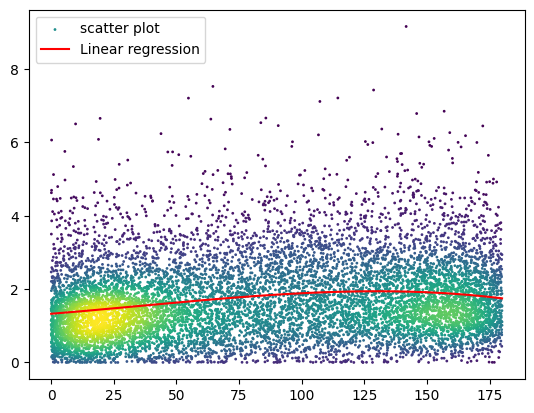

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.01 * x + 1.33
MSE: 1.1082691
R^2: 0.03643500804901123


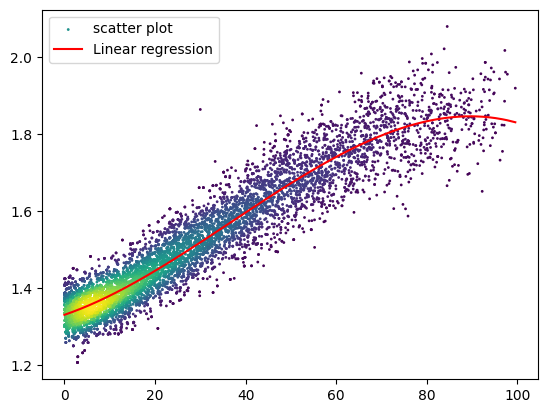

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.33
MSE: 0.0024932874869787163
R^2: 0.8980249049573732
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


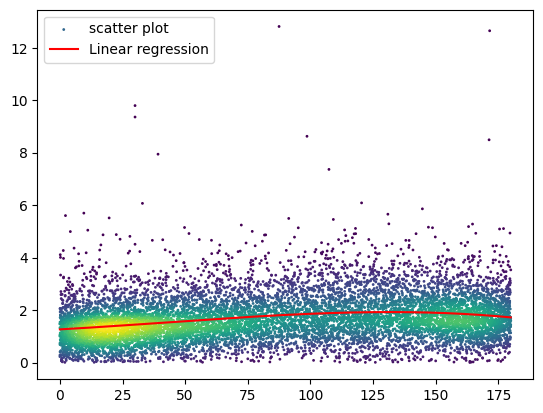

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.01 * x + 1.26
MSE: 0.7287208
R^2: 0.0617673397064209


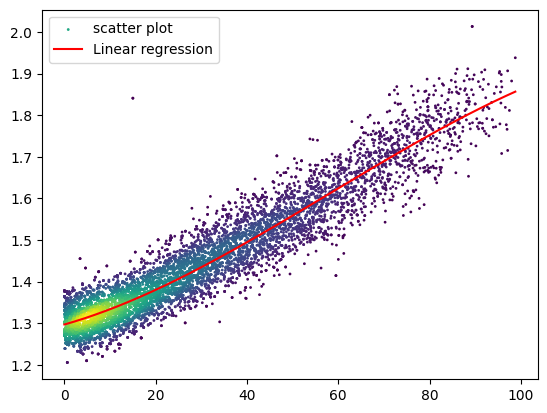

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.3
MSE: 0.0018880480855805843
R^2: 0.892795918785239
____________________________________________________________________________________________________ 
 snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser


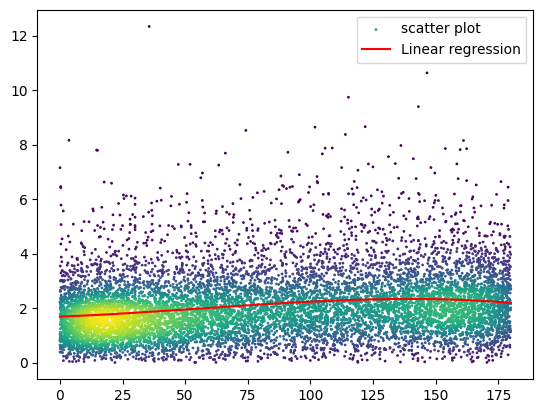

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.69
MSE: 1.2943302
R^2: 0.038568854331970215


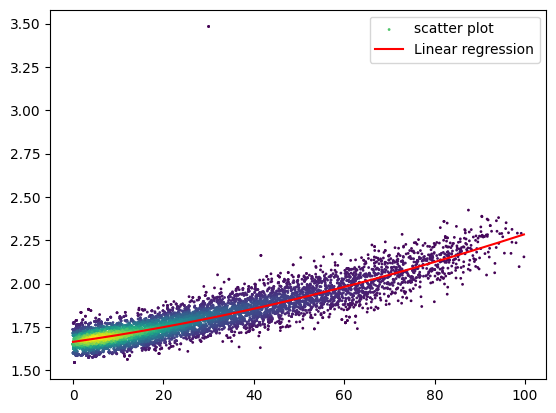

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.66
MSE: 0.003667977103235879
R^2: 0.807045017777972
____________________________________________________________________________________________________ 
 snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser


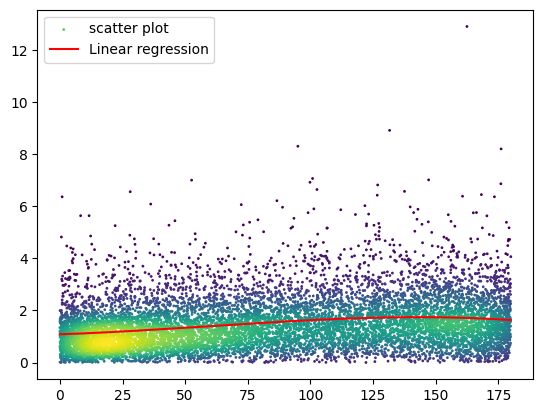

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.08
MSE: 0.8970007
R^2: 0.056298911571502686


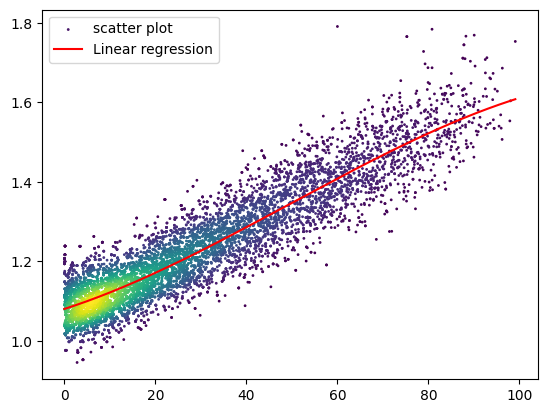

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.08
MSE: 0.0029592329608630515
R^2: 0.8361756002556322
____________________________________________________________________________________________________ 
 snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser


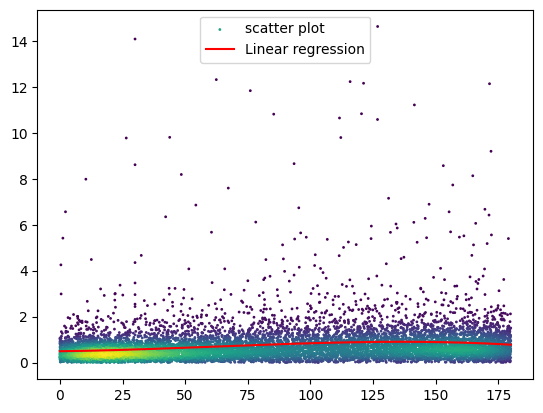

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 0.49
MSE: 0.6042832
R^2: 0.03416597843170166


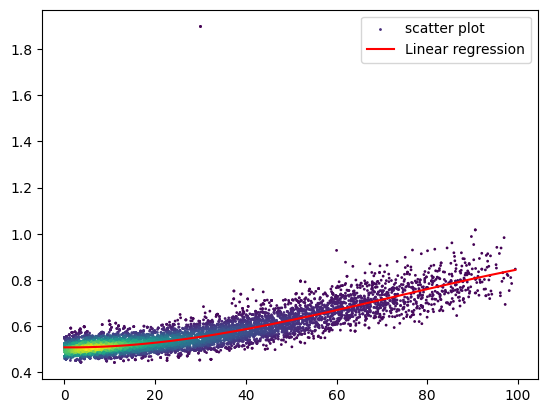

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.0 * x + 0.51
MSE: 0.0016133266862803652
R^2: 0.7478584485190354
____________________________________________________________________________________________________ 
 HS_c_20220223_1m_epsg2056


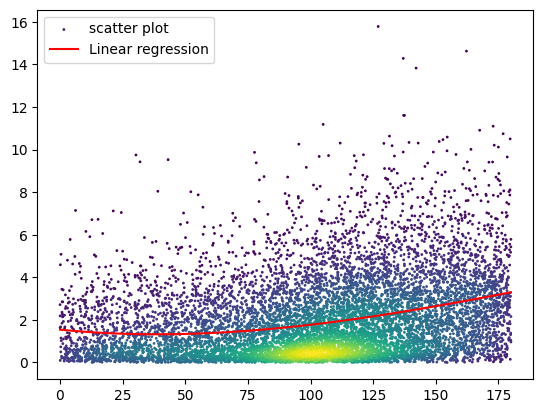

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.01 * x + 1.54
MSE: 3.0784407
R^2: 0.08907347917556763


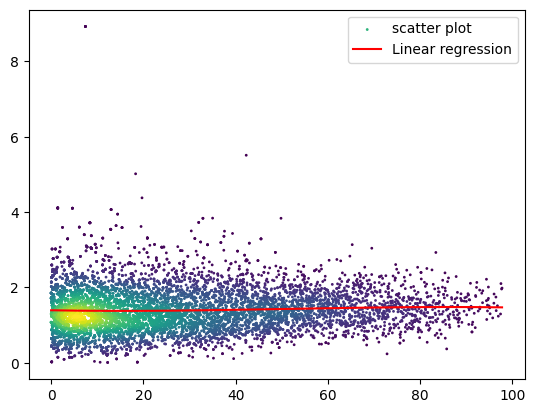

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.0 * x + 1.39
MSE: 0.3492843561743186
R^2: 0.0020804888311347636
____________________________________________________________________________________________________ 
 HS_Davos_20170316_2m_epsg2056


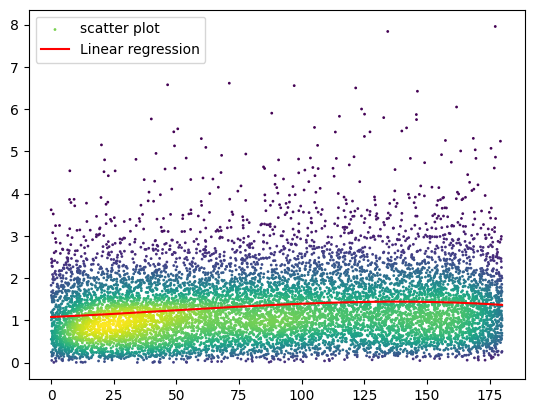

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.08
MSE: 0.67486733
R^2: 0.020499467849731445


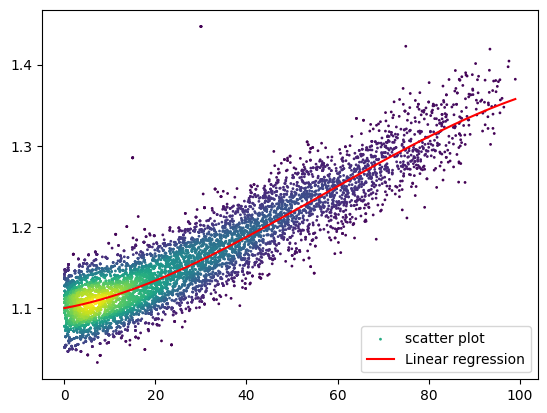

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 1.1
MSE: 0.0006768635156106037
R^2: 0.8287963038200483
____________________________________________________________________________________________________ 
 HS_Davos_20180411_2m_epsg2056


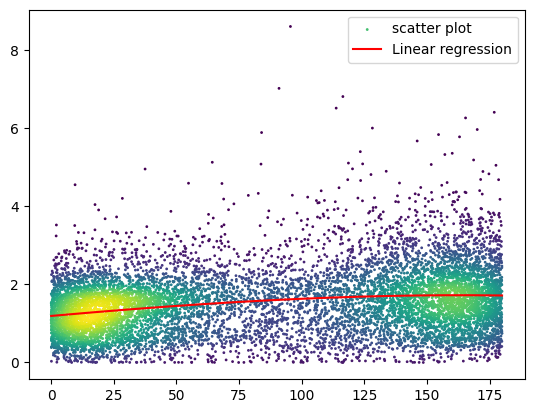

Fitted function: -0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.19
MSE: 0.623362
R^2: 0.05733847618103027


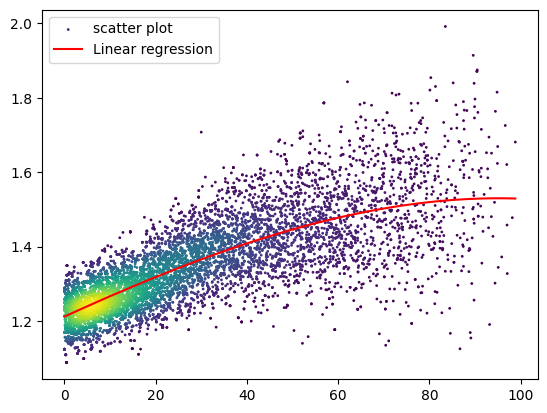

Fitted function: -0.0 * x^3 + -0.0 * x^2 + 0.01 * x + 1.21
MSE: 0.005573137073421898
R^2: 0.6007340835229833
____________________________________________________________________________________________________ 
 snowmap_20160420_ads_100_extent_maskiert_nosnow0_noausreisser


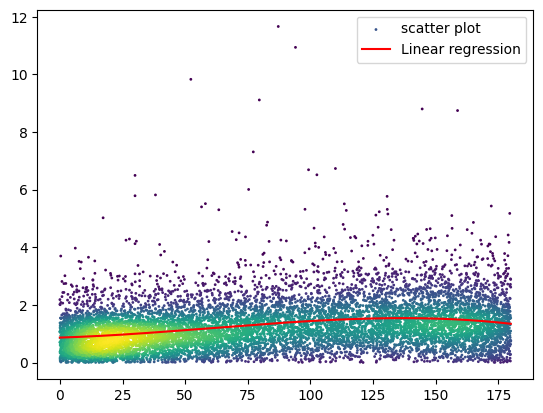

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 0.87
MSE: 0.6191782
R^2: 0.08390682935714722


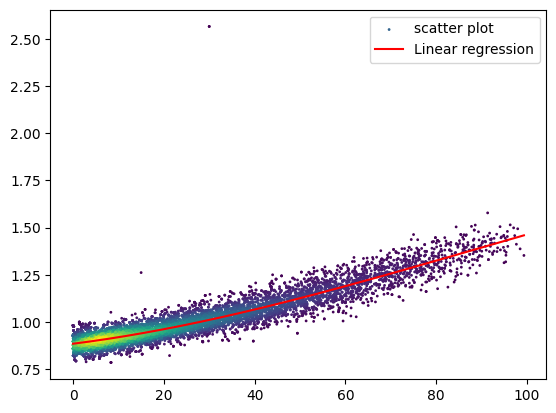

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.0 * x + 0.89
MSE: 0.002393529959085814
R^2: 0.8546785107264214
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220224_2m_epsg2056


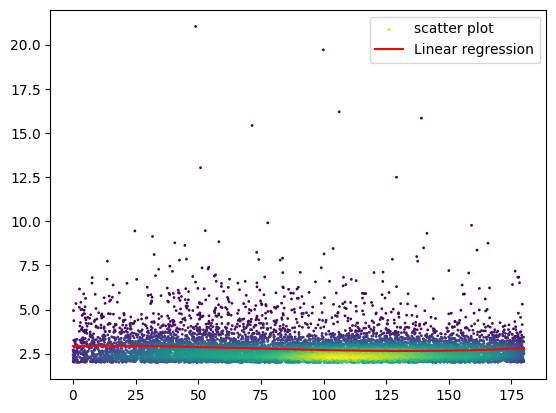

Fitted function: 0.0 * x^3 + -0.0 * x^2 + 0.0 * x + 2.94
MSE: 0.69510126
R^2: 0.013986706733703613


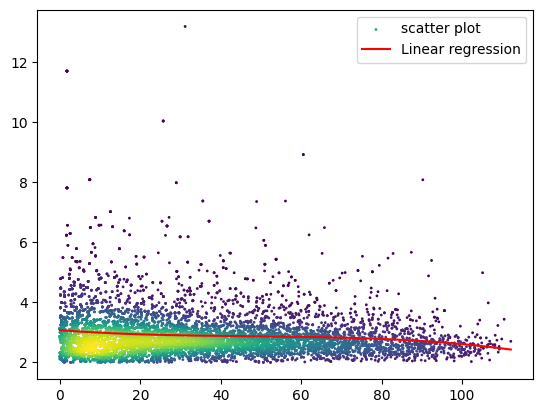

Fitted function: -0.0 * x^3 + 0.0 * x^2 + -0.01 * x + 3.08
MSE: 0.5869544627631239
R^2: 0.013982753514857671
____________________________________________________________________________________________________ 
 snowmap_2010_ads_80_extent_maskiert_nosnow0_noausreisser


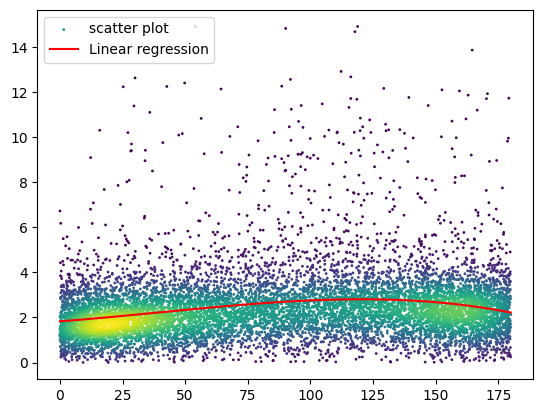

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.01 * x + 1.83
MSE: 2.0519295
R^2: 0.04398548603057861


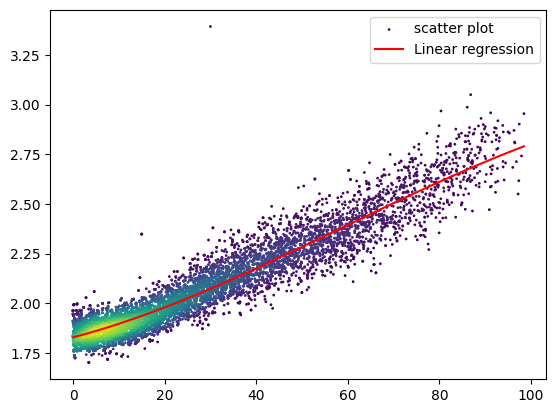

Fitted function: -0.0 * x^3 + 0.0 * x^2 + 0.01 * x + 1.83
MSE: 0.005312057898449497
R^2: 0.8972017180188593


In [47]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)